# Multinomial Logistic Regression

In [1]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

First, we load the data:

In [3]:
# Dataframe
path_df = "C:/Users/Keletso/Documents/Research Paper Classification/2. Feature Engineering/Pickles/df_train.pickle"
with open(path_df, 'rb') as data:
    df = pickle.load(data)

# features_train
path_features_train = "C:/Users/Keletso/Documents/Research Paper Classification/2. Feature Engineering/Pickles/features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = "C:/Users/Keletso/Documents/Research Paper Classification/2. Feature Engineering/Pickles/labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = "C:/Users/Keletso/Documents/Research Paper Classification/2. Feature Engineering/Pickles/features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = "C:/Users/Keletso/Documents/Research Paper Classification/2. Feature Engineering/Pickles/labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)

## Cross-Validation for Hyperparameter tuning

First, we lets see what hyperparameters the model has:

In [4]:
lr_0 = LogisticRegression(random_state = 8)

print('Parameters currently in use:\n')
pprint(lr_0.get_params())

Parameters currently in use:

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 8,
 'solver': 'warn',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


We'll tune the following ones:

* `C` = Inverse of regularization strength. Smaller values specify stronger regularization.
* `multi_class` = We'll choose `multinomial` because this is a multi-class problem.
* `solver` = Algorithm to use in the optimization problem. For multiclass problems, only `newton-cg`, `sag`, `saga` and `lbfgs` handle multinomial loss.
* `class_weight`: Weights associated with classes. 
* `penalty`: Used to specify the norm used in the penalization. The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties.

### Randomized Search Cross Validation

We first need to define the grid:

In [5]:
# C
C = [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 5)]

# multi_class
multi_class = ['multinomial']

# solver
solver = ['newton-cg', 'sag', 'saga', 'lbfgs']
 
# class_weight
class_weight = ['balanced', None]

# penalty
penalty = ['l2']

# Create the random grid
random_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

pprint(random_grid)

{'C': [0.1, 0.325, 0.55, 0.775, 1.0],
 'class_weight': ['balanced', None],
 'multi_class': ['multinomial'],
 'penalty': ['l2'],
 'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']}


We perform the Random Search:

In [8]:
# First create the base model to tune
lrc = LogisticRegression(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=lrc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   n_jobs=-1,
                                   verbose=1,
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

C:\Users\Keletso\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 40 is smaller than n_iter=50. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 41.4min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l2', random_state=8,
                                                solver='warn', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='warn', n_iter=50, n_jobs=-1,
                   param_distributions={'C': [0.1, 0.325, 0.55, 0.775, 1.0],
                                        'class_weight': ['balanced', None],
                                        'multi_class': ['multinomial'],
                                        'penalty': [

We can see the best hyperparameters resulting from the Random Search:

In [10]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'solver': 'newton-cg', 'penalty': 'l2', 'multi_class': 'multinomial', 'class_weight': None, 'C': 0.775}

The mean accuracy of a model with these hyperparameters is:
0.8053913154046666


We can do a more exhaustive search centered in those values:

In [14]:
# Create the parameter grid based on the results of random search 
C = [float(x) for x in np.linspace(start = 0.7, stop = 0.85, num = 5)]
multi_class = ['multinomial']
solver = ['newton-cg']
class_weight = [None]
penalty = ['l2']

param_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

# Create a base model
lrc = LogisticRegression(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=lrc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           n_jobs=-1,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.6min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=8, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.7, 0.7374999999999999, 0.7749999999999999,
                               0.8125, 0.85],
                         'class_weight': [None], 'multi_class': ['multinomial'],
                         'penalty': ['l2'], 'solver': ['newt

In [15]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 0.85, 'class_weight': None, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg'}

The mean accuracy of a model with these hyperparameters is:
0.8082578822320683


Let's save the model in `best_lrc`:

In [16]:
best_lrc = grid_search.best_estimator_

In [17]:
best_lrc

LogisticRegression(C=0.85, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=8, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

We now know the best logistic regression model. Let's fit it and see how it performs:

## Model fit and performance

Now, we can fit the model to our training data:

In [19]:
best_lrc.fit(features_train, labels_train)

LogisticRegression(C=0.85, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=8, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

And get the predictions:

In [20]:
lrc_pred = best_lrc.predict(features_test)

#### Training accuracy

In [21]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_lrc.predict(features_train)))

The training accuracy is: 
0.8551719753321889


#### Test accuracy

In [22]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, lrc_pred))

The test accuracy is: 
0.8191874880793439


#### Classification report

In [23]:
# Classification report
print("Classification report")
print(classification_report(labels_test,lrc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      2163
           1       0.90      0.91      0.91      1384
           2       0.83      0.83      0.83      1127
           3       0.50      0.23      0.31       418
           4       0.70      0.19      0.30        99
           5       0.68      0.29      0.41        52

    accuracy                           0.82      5243
   macro avg       0.73      0.56      0.60      5243
weighted avg       0.80      0.82      0.80      5243



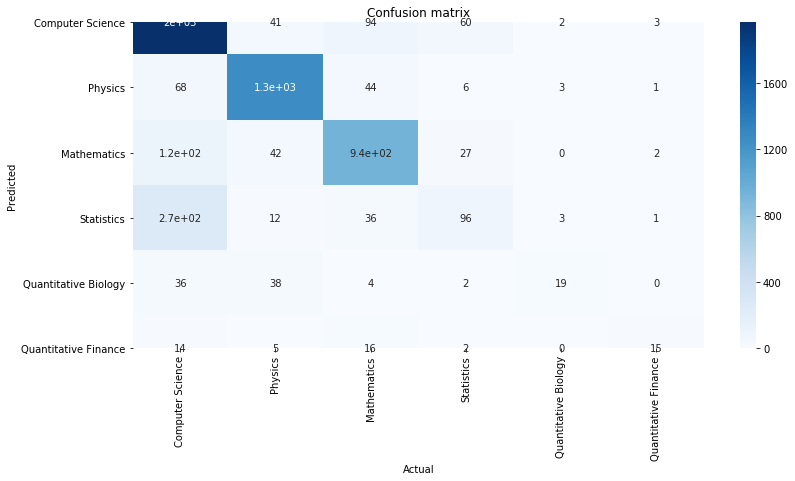

In [24]:
aux_df = df[['Research Field', 'Research Field Code']].drop_duplicates().sort_values('Research Field Code')
conf_matrix = confusion_matrix(labels_test, lrc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Research Field'].values, 
            yticklabels=aux_df['Research Field'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

Let's see if the hyperparameter tuning process has returned a better model:

In [25]:
base_model = LogisticRegression(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

C:\Users\Keletso\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Keletso\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.8212855235552164

In [26]:
best_lrc.fit(features_train, labels_train)
accuracy_score(labels_test, best_lrc.predict(features_test))

0.8191874880793439

Approximately the same, however it looks like the the dafault model produced a slightly better result.

We'll create a dataset with a model summary to compare models:

In [27]:
d = {
     'Model': 'Logistic Regression',
     'Training Set Accuracy': accuracy_score(labels_train, best_lrc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, lrc_pred)
}

df_models_lrc = pd.DataFrame(d, index=[0])

In [28]:
df_models_lrc

,Model,Training Set Accuracy,Test Set Accuracy
0,Logistic Regression,0.855172,0.819187


In [29]:
with open('Models/best_lrc.pickle', 'wb') as output:
    pickle.dump(best_lrc, output)
    
with open('Models/df_models_lrc.pickle', 'wb') as output:
    pickle.dump(df_models_lrc, output)